# Terrain Classification
### Created by Keenan McConkey 2019.5.17

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
import pandas as pd

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats
import sklearn.preprocessing as pre
from datetime import datetime
from decimal import Decimal

import pymrmr

## Part 1 - Importing Datasets

### Part (0) - Functions for Data Import

In [2]:
# Easier to read column names - Convention is different for older datasets
frame_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Epoch Time']
std_columns =   ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']
data_columns =  ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']

# Columns not currently used for classification - Usually for phone data
unused_columns = ['LINEAR ACCELERATION X (m/s²)', 'LINEAR ACCELERATION Y (m/s²)', 'LINEAR ACCELERATION Z (m/s²)',
                  'GRAVITY X (m/s²)', 'GRAVITY Y (m/s²)', 'GRAVITY Z (m/s²)', 
                  'MAGNETIC FIELD X (μT)', 'MAGNETIC FIELD Y (μT)', 'MAGNETIC FIELD Z (μT)',
                  'ORIENTATION X (pitch °)', 'ORIENTATION Y (roll °)', 'ORIENTATION Z (azimuth °)',
                  'MagX', 'MagY', 'MagZ']

'''Get columns for given label'''
def get_columns(_label):
    columns = []
    
    # New naming scheme
    if 'Phone' in _label or 'Wheel' in _label or 'Module' in _label:
        columns = std_columns.copy()
    # Old frame data naming scheme
    elif 'Frame' in _label:
        columns = frame_columns.copy()
    else:
        raise Exception('Unknown label')
    
    # For transformed datasets replace time columns with frequency
    if 'FFT' in _label or 'PSD' in _label:
        columns.remove('Epoch Time')
        
        if 'Run Time' in columns:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [3]:
# Types of terrain tested and placements on the wheelchair
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
placements = ['Left', 'Right', 'Middle']

'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

### Part (a) - Parsing Data into Pandas

In [4]:
# Find .csv files
raw_datasets = {}
dataset_paths = glob.glob('imu_data/set_full/*.csv')

In [5]:
# Import datasets as an array of Pandas DataFrames
TRIM_LEN = 2000 # Number of data points to trim from each side (10s at 200 Hz)
N_DATA_COL = 6 # Number of columns containing directional data

dataset_labels = []

for dataset_path in dataset_paths:
    # Parse labels from filenames
    dataset_label = dataset_path.split(' ')[-1].split('/')[-1].split('.')[0]
    dataset_labels.append(dataset_label)

    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)

    # Drop unused columns
    for to_remove in unused_columns:
        if to_remove in dataset.columns:
            dataset = dataset.drop(to_remove, axis=1)

    # Rename columns to something easier to work with
    dataset.columns = get_columns(dataset_label)
    
    # Convert timestamps to epoch time in s
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.strptime, args=("%Y-%m-%d %H:%M:%S:%f",))
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.timestamp)
    
    # Remove gravitational acceleration from Frame and Middle Phone data
    ## Can't remove from wheel-mounted devices because they rotate over time
    if 'Middle' in dataset_label:
        # Calculate gravity from last 2000 datapoints and subtract from Z Zccel
        ## We need to calculate it manually because device may not be exactly parallel to terrain
        #g_z = dataset.loc[-2000:]['Z Accel'].mean()

        # Using 9.81 instead
        g_z = 9.81
        dataset['Z Accel'] = dataset['Z Accel'].apply(lambda x: x - g_z)
    
    
    # Trim edges to account for startup time
    ## Not necessary if we can remove gravity when IMUs are stationary
    ## i.e. Make stationary IMU have zero contribution to FFT
    dataset = dataset[TRIM_LEN:-TRIM_LEN]
    
    # Datasets are stored in a dictionary
    raw_datasets.update({dataset_label: dataset})

In [6]:
# List all datasets
dataset_labels

['Left_AsphaltStraight2_Module',
 'Middle_CarpetPowerDonut_Module',
 'Left_GrassStraight2_Module',
 'Right_AsphaltDonut_Module',
 'Left_Asphalt_Module',
 'Middle_SidewalkDonut_Module',
 'Middle_AsphaltPowerDonut_Module',
 'Right_GravelStraight_Module',
 'Left_ConcreteStraight2_Module',
 'Right_SidewalkStraight2_Module',
 'Middle_GravelPowerDonut_Module',
 'Right_Gravel_Module',
 'Middle_CarpetStraight_Module',
 'Left_GravelStraight_Module',
 'Left_CarpetStraight_Module',
 'Middle_ConcretePowerStraight2_Module',
 'Middle_Asphalt_Module',
 'Right_AsphaltStraight2_Module',
 'Right_Asphalt_Module',
 'Middle_GrassStraight_Module',
 'Middle_ConcretePowerStraight_Module',
 'Middle_ConcretePowerDonut_Module',
 'Left_GravelDonut_Module',
 'Middle_AsphaltPower_Module',
 'Right_GrassStraight_Module',
 'Middle_CarpetPowerStraight_Module',
 'Right_LinoleumStraight_Module',
 'Middle_GrassPower_Module',
 'Right_Carpet_Module',
 'Left_AsphaltStraight_Module',
 'Middle_ConcreteStraight_Module',
 'Right

In [7]:
# Check dataset validity
raw_datasets[dataset_labels[0]].head()

X Accel   Y Accel   Z Accel    X Gyro    Y Gyro   Z Gyro   Run Time  \
2000 -6.228420 -6.407983  2.254705  0.019731 -0.199485  4.34627   9.999872   
2001 -7.734350 -6.410377  1.408368 -0.027540 -0.256876  4.34627  10.004992   
2002 -8.463373 -7.445853 -1.688485 -0.003838 -0.160603  4.34627  10.009856   
2003 -4.796710 -7.643372 -1.714821  0.024525 -0.138365  4.34627  10.014976   
2004 -7.548802 -4.571658 -0.757155  0.055684 -0.228513  4.34627  10.019840   

        Epoch Time  
2000  1.561068e+09  
2001  1.561068e+09  
2002  1.561068e+09  
2003  1.561068e+09  
2004  1.561068e+09

It looks like the update rate of the IMU is non deterministic and lower than the rate the phone samples it at, i.e. the phone receives a non-deterministic number of sequential identical measurements from the IMU when polling at approx 200 Hz.

### Part (b) - Visualizing Time Domain Data

In [8]:
'''Plot a single dataset in one direction'''
def plot_one(dataset_name, y_column, x_column, xlim=None, save_fig=False):
    plt.clf()
    plt.figure(figsize=(20, 5))
    
    plt.plot(raw_datasets[dataset_name][x_column], raw_datasets[dataset_name][y_column])
    plt.title(dataset_name)
    plt.xlabel(x_column)
    
    if 'Accel' in y_column:
        plt.ylabel(y_column + '($m/s^2$)')
    elif 'Gyro' in y_column:
        plt.ylabel(y_column + '($rad/s$)')
    else:
        plt.ylabel('Unknown')
    
    if xlim is not None:
        plt.xlim = xlim
    
    if save_fig is True:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/img/' + dataset_name + '.png'
        plt.savefig(save_name)
    else:    
        plt.show()

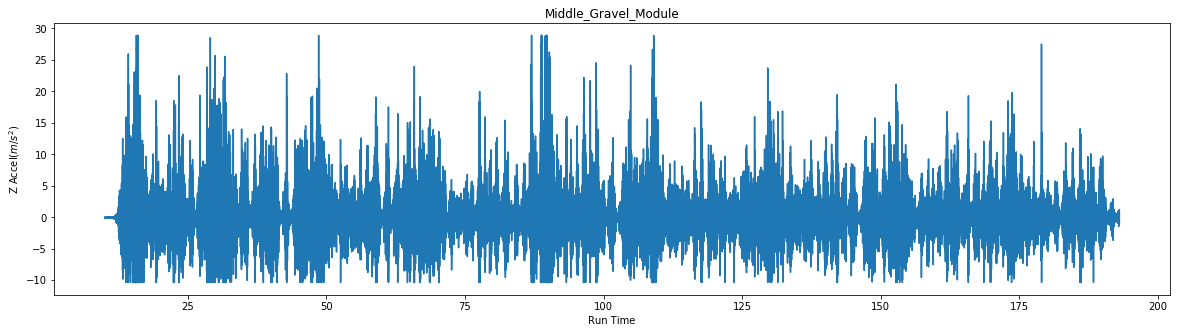

In [9]:
# Test plot - Data range is cutoff!
plot_one('Middle_Gravel_Module', 'Z Accel', 'Run Time')

In [10]:
#Plot every dataset Z Accel and save images
#for label in dataset_labels:
#    plot_one(label, 'Z Accel', 'Run Time', save_fig=True)

In [11]:
'''Compare two Pandas DataFrames by Epoch Time'''
def dataset_compare(dataset1, label1, dataset2, label2, dirn, t_offset=0, y_offset=0):
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 5))
    
    # Plot data with given y and t offsetson first dataset
    ax.plot(dataset1[label1]['Epoch Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][dirn].apply(lambda y: y + y_offset), label=label1)
    ax.plot(dataset2[label2]['Epoch Time'], 
            dataset2[label2][dirn], label=label2)
    
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel(dirn)
    ax.set_title(dirn + ' for ' + label1 + ' and ' + label2)
    
    # Plot offset info
    offset_text = 'Offsets\n'
    offset_text += ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

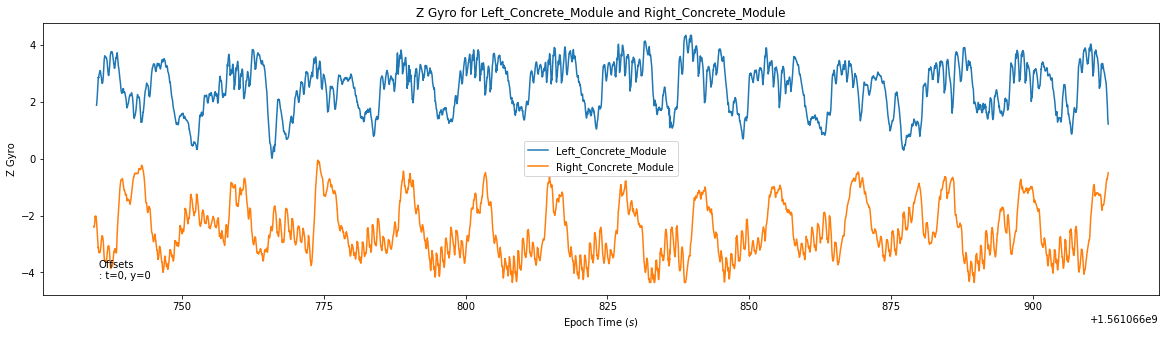

In [12]:
# Compare Z Z Gyro data for each wheel in the same dataset
dataset_compare(raw_datasets, 'Left_Concrete_Module',
                raw_datasets, 'Right_Concrete_Module', 'Z Gyro')

In [13]:
'''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, windowed=False, win_num=0, take_row=False):
    plt.clf()
    
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 1
    
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
        
    axes = []
    row, col = 0, 0
    
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes and take_row): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis)
        axes[i].set_ylabel(y_axis)
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

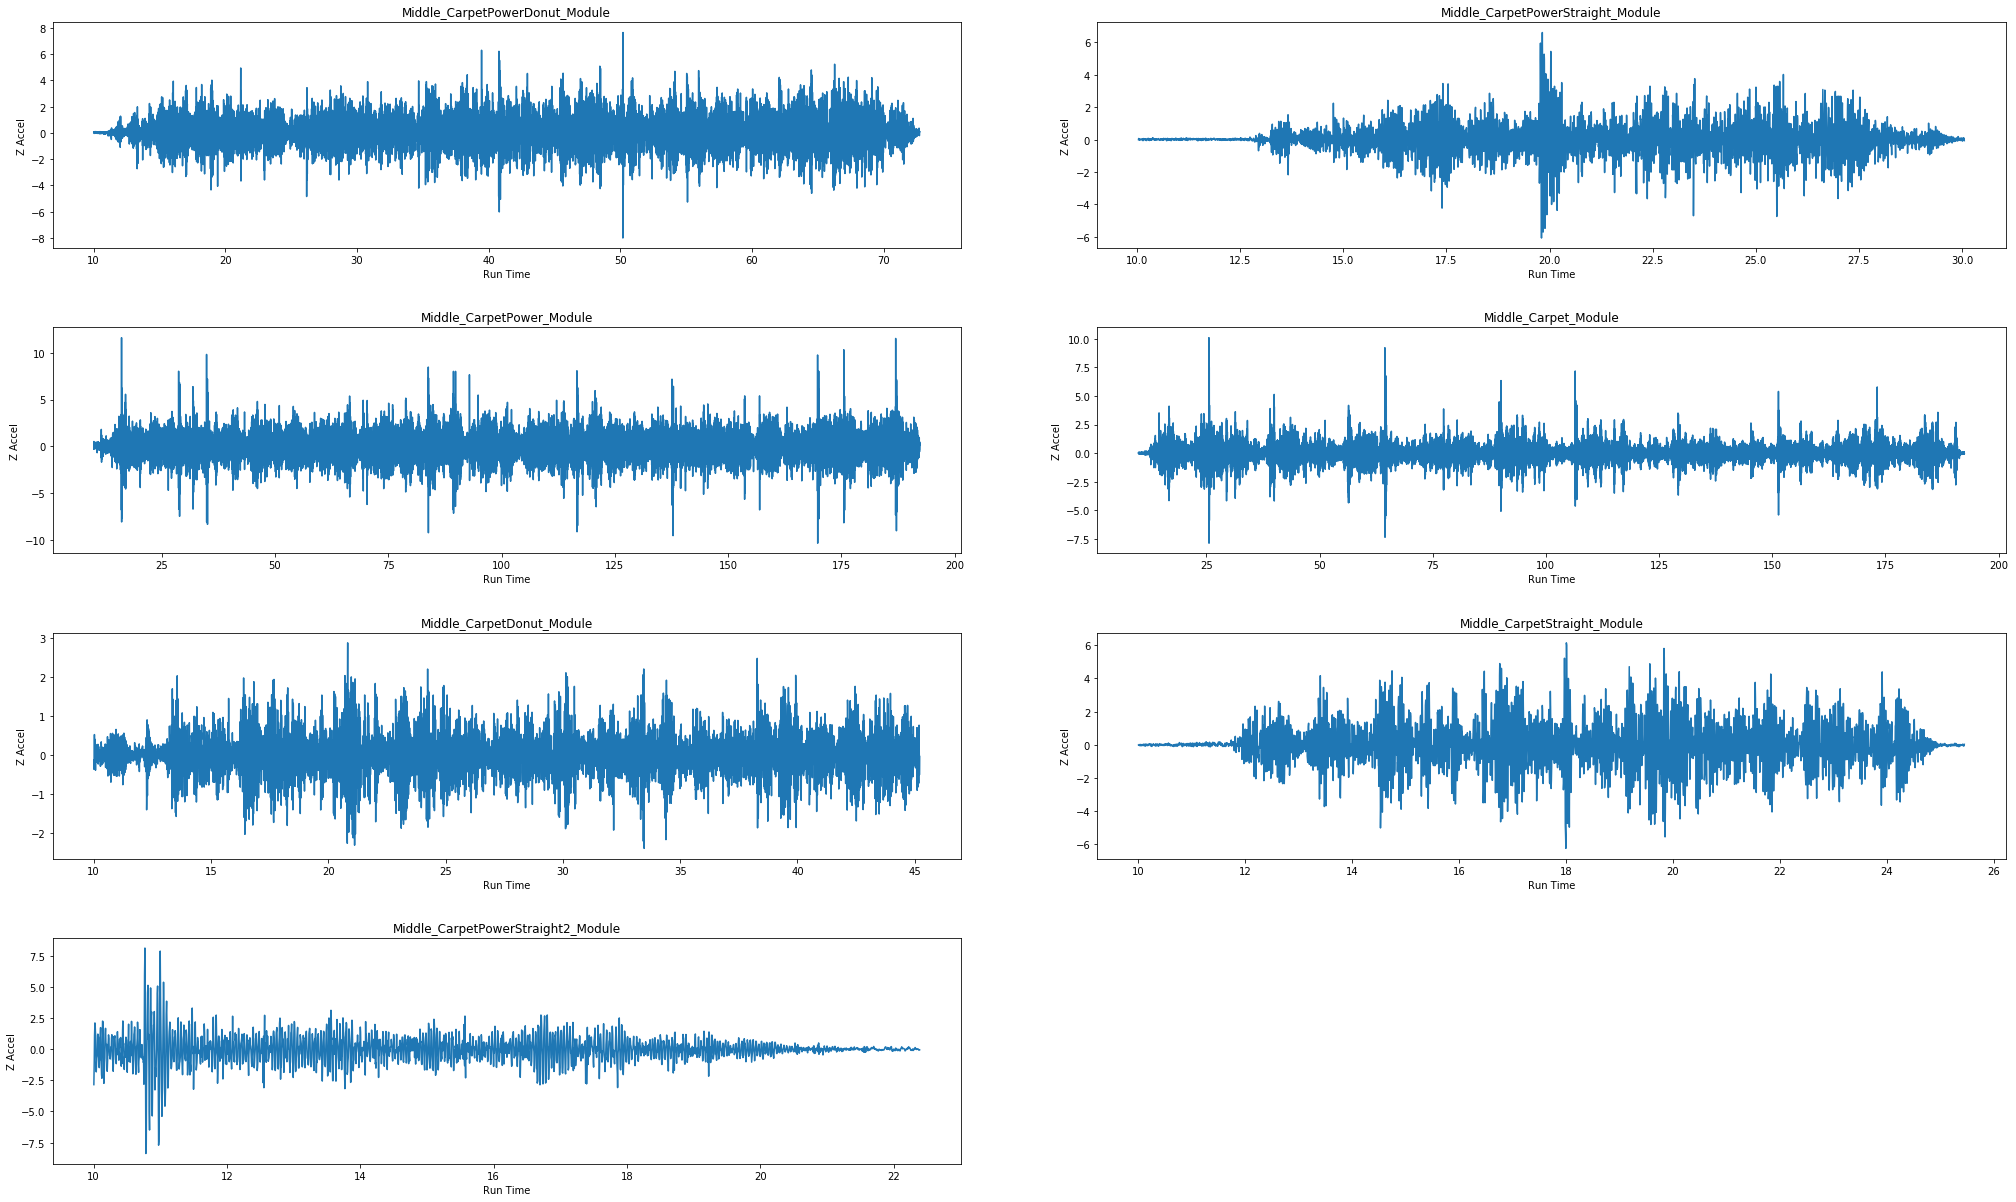

In [14]:
# Plot Z Accel of some datasets
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() if 'Middle' in label and 'Carpet' in label}
plot_all(datasets_to_plot, x_axis='Run Time', y_axis='Z Accel')

### Part (c) - Converting Between Pandas and Numpy

In [15]:
'''Convert array of Pandas DataFrames to array of 2D Numpy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.as_matrix()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [16]:
'''Convert array of 2D Numpy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))
                
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [17]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [18]:
# Run to convert back to Pandas
#raw_dataset = np_to_pd(raw_datasets)

In [19]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Number of datasets: 105
Shape of first dataset: (2496, 8)


Structure of data:

`Terrain Dataset Dictionary -> NP Array with Row = Datapoint, Col = Direction | Time`

## Part 2 - Filtering

Datasheets of smartphone level IMUs suggest that IMU filters data before sending it to the phone, and that the cutoff frequency of this filtering is configurable and changes with update frequency.

Based on the IMU update rate of about 20 ms, this cutoff frequency is already close to 40 Hz, so filtering is probably unnecessary. Its hard to be sure about actual values because this is configured by the phone manufacturer.

In [20]:
'''Get frequencies for given label'''
def get_frequencies(label):
    # Sampling frequency varies for different devices (old datasets only)
    if ('Frame' in label):
        f_samp = 100 # Sampling frequency
        f_low = 20 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
    else:
        f_samp = 200 # Sampling frequency
        f_low = 40 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
        
    return f_samp, f_low, f_high

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

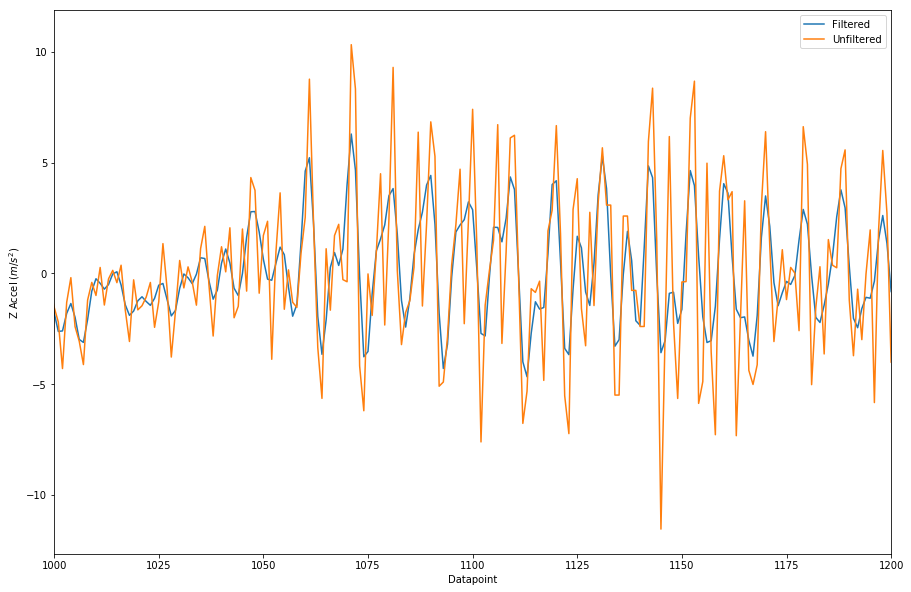

In [21]:
# Filtered datasets dictionary
datasets = {}

for label, raw_dataset in raw_datasets.items():
    
    # Sampling rates are not consistent across all datasets
    f_samp, f_low, f_high = get_frequencies(label)
    
    # Get normalized frequencies
    w_low = f_low / (f_samp / 2) 
    w_high = f_high / (f_samp / 2)

    # Get Butterworth filter parameters
    b_butter, a_butter = signal.butter(N=4, Wn=w_low, btype='low')
    
    dataset = np.copy(raw_dataset)
    for i in range(N_DATA_COL):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, dataset[:, i])
        
    datasets.update({label: dataset})

# Compare filtered and unfiltered
plt.clf()
plt.figure(figsize=(15, 10))
plt.plot(datasets[dataset_labels[0]][:, 2], label='Filtered')
plt.plot(raw_datasets[dataset_labels[0]][:, 2], label='Unfiltered')
plt.xlim(1000, 1200)
plt.legend()
plt.xlabel('Datapoint')
plt.ylabel('Z Accel ($m/s^2$)')
plt.show()

In [22]:
## Check construction
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 105
Shape of first filtered dataset: (2496, 8)


In [23]:
# Verify we can convert back to Pandas
np_to_pd(datasets, windowed=False)[dataset_labels[0]].head()

X Accel   Y Accel   Z Accel    X Gyro    Y Gyro   Z Gyro   Run Time  \
0 -6.230691 -6.408834  2.256243  0.019728 -0.199450  4.34627   9.999872   
1 -7.210531 -7.077212  0.155472 -0.013201 -0.195033  4.34627  10.004992   
2 -7.357456 -7.197219 -1.366994 -0.013145 -0.189479  4.34627  10.009856   
3 -6.877169 -6.629091 -1.523442  0.024604 -0.184868  4.34627  10.014976   
4 -6.646504 -5.744731 -0.136157  0.072773 -0.178787  4.34627  10.019840   

     Epoch Time  
0  1.561068e+09  
1  1.561068e+09  
2  1.561068e+09  
3  1.561068e+09  
4  1.561068e+09

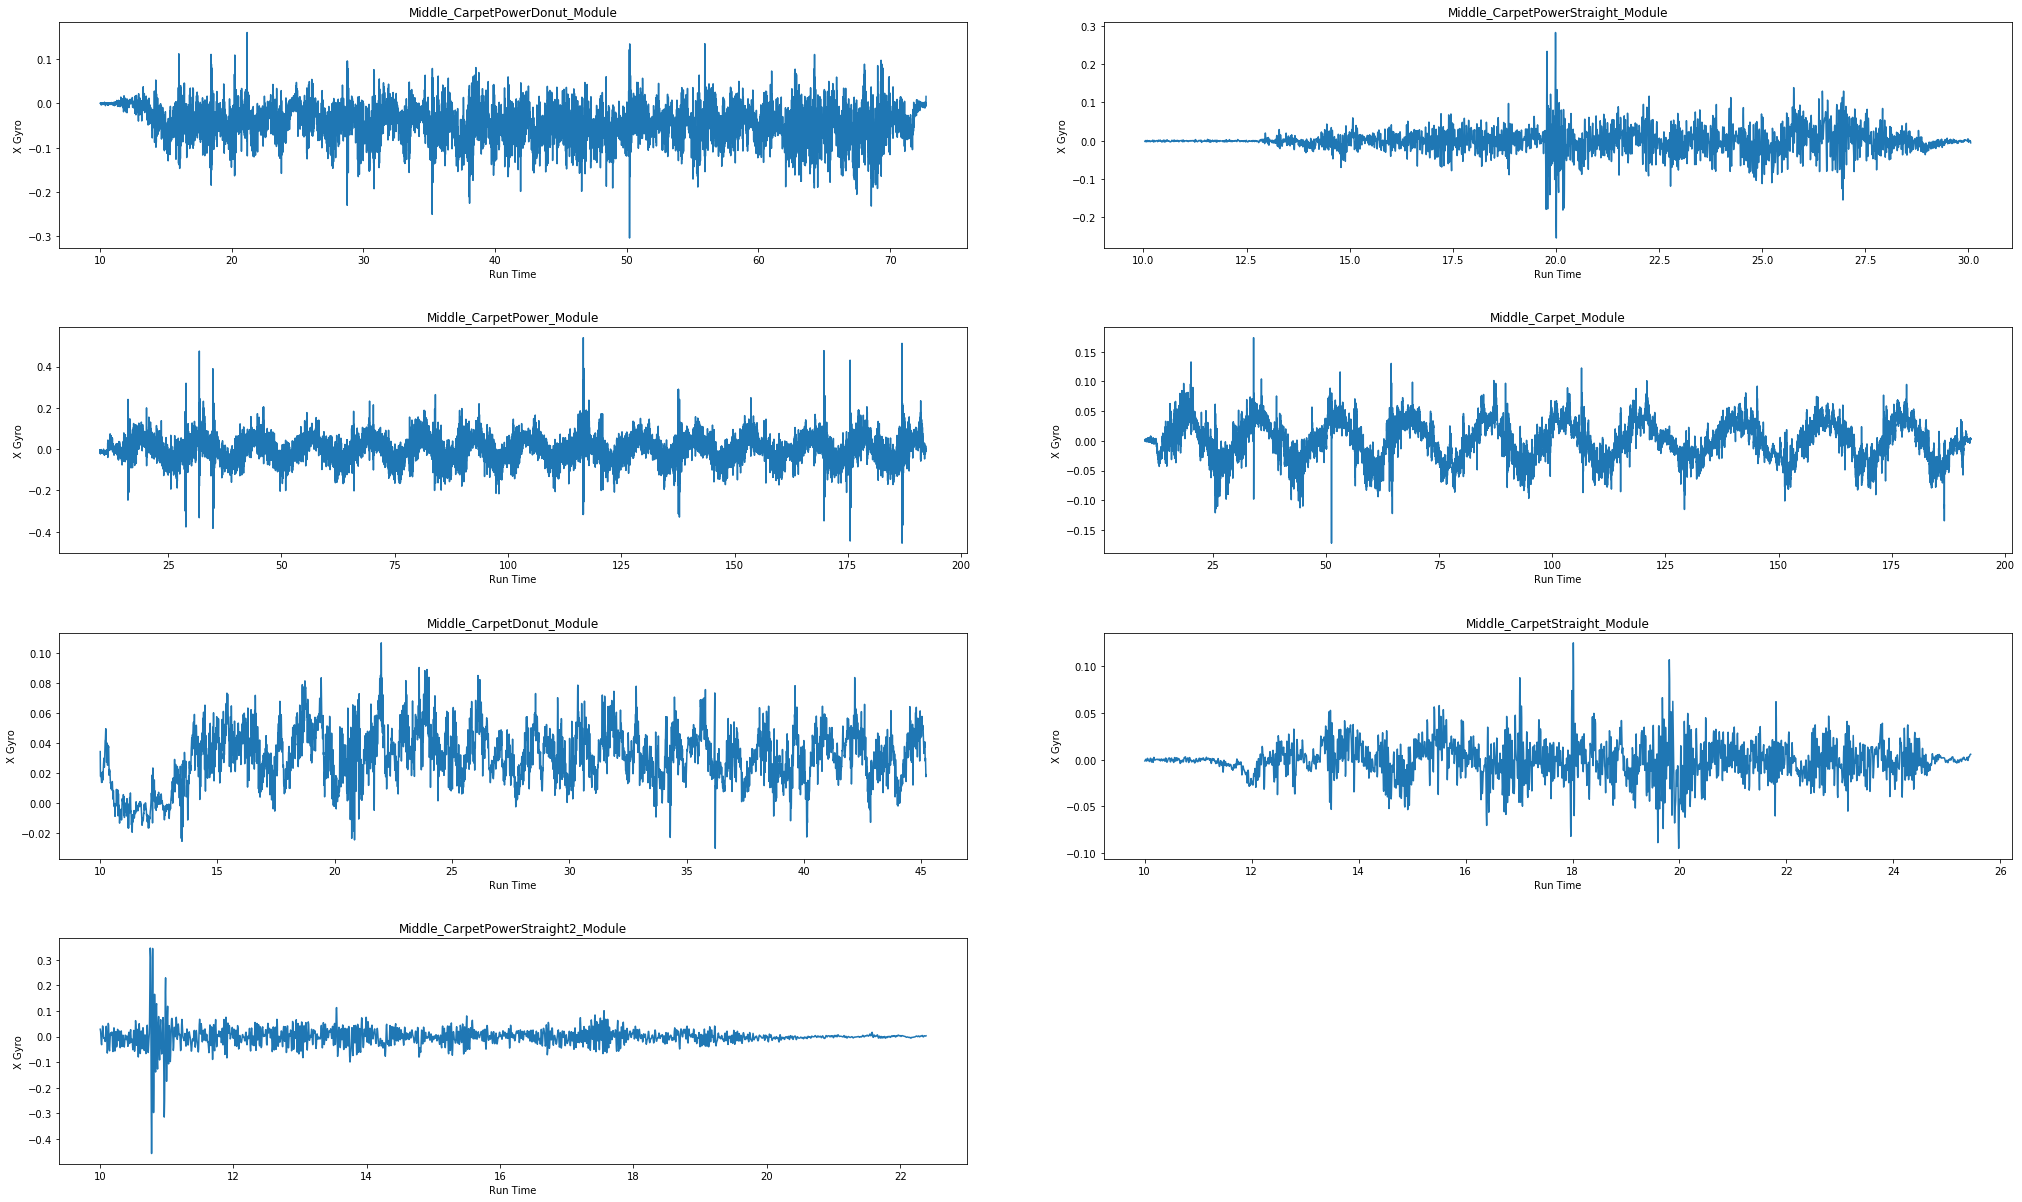

In [24]:
# Plot Z Accel of some filtered datasets
datasets_to_plot = {label: dataset for label, dataset in datasets.items() if 'Middle' in label and 'Carpet' in label}
plot_all(np_to_pd(datasets_to_plot), x_axis='Run Time', y_axis='X Gyro')

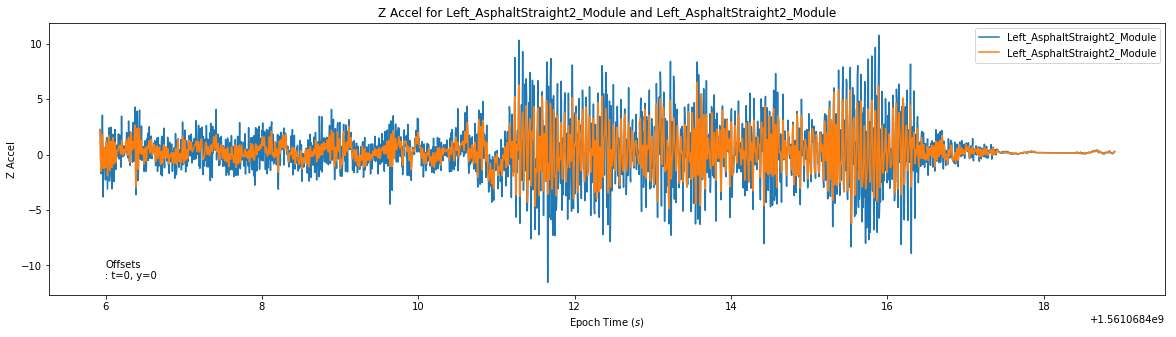

In [25]:
# Compare filtered and unfiltered data
dataset_compare(np_to_pd(raw_datasets), dataset_labels[0], 
                np_to_pd(datasets), dataset_labels[0], 'Z Accel')

## Part 3 - Time Windows

### Part (a) - Finding an optimal time window

Strategy is to start with a large time window and work down. 

Plot classification accuracy and time vs window size and find an optimal size

### Part (b) - Creating Time Windowed Data

In [26]:
# TODO: Create an array of different window sizes, taking out the desired array so don't have to rename things

WINDOW_SIZE = 400 # Divide by F_SAMP to get window size in seconds
datasets_windowed = {}

#raw_datasets = {label: dataset for label, dataset in raw_datasets.items() if 'Middle' in label}
# Trim excess datapoints, then split into windows
for label, dataset in raw_datasets.items():   
    n_windows = int(len(dataset) / WINDOW_SIZE)
    n_points = n_windows*WINDOW_SIZE
    
    dataset_windowed = np.resize(dataset, (n_points, dataset.shape[1]))
    dataset_windowed = np.split(dataset_windowed, n_windows, axis=0)
    
    datasets_windowed.update({label: dataset_windowed})

In [27]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 105
Num of windows in first dataset: 6
Shape of individual window: (400, 8)


Structure of windowed data:

`Terrain Dataset Dictionary -> Window List -> NP Array with Row = Datapoint, Col = Direction | Time`

In [28]:
# Try out pandas conversion again
np_to_pd(datasets_windowed, windowed=True)[dataset_labels[0]][0].tail()

X Accel    Y Accel   Z Accel    X Gyro    Y Gyro   Z Gyro   Run Time  \
395 -8.141358   8.405913  0.090380 -0.023812 -0.177114  4.34627  11.974912   
396 -9.933391   9.314499 -2.761071 -0.142455 -0.233573  4.34627  11.980032   
397 -7.385999   7.369240  1.408368 -0.113427 -0.077911  4.34627  11.984896   
398 -7.274670   7.994117  2.424691 -0.055104 -0.133438  4.34627  11.990016   
399 -8.987696  10.930560  0.183752 -0.032467 -0.190164  4.34627  11.994880   

       Epoch Time  
395  1.561068e+09  
396  1.561068e+09  
397  1.561068e+09  
398  1.561068e+09  
399  1.561068e+09

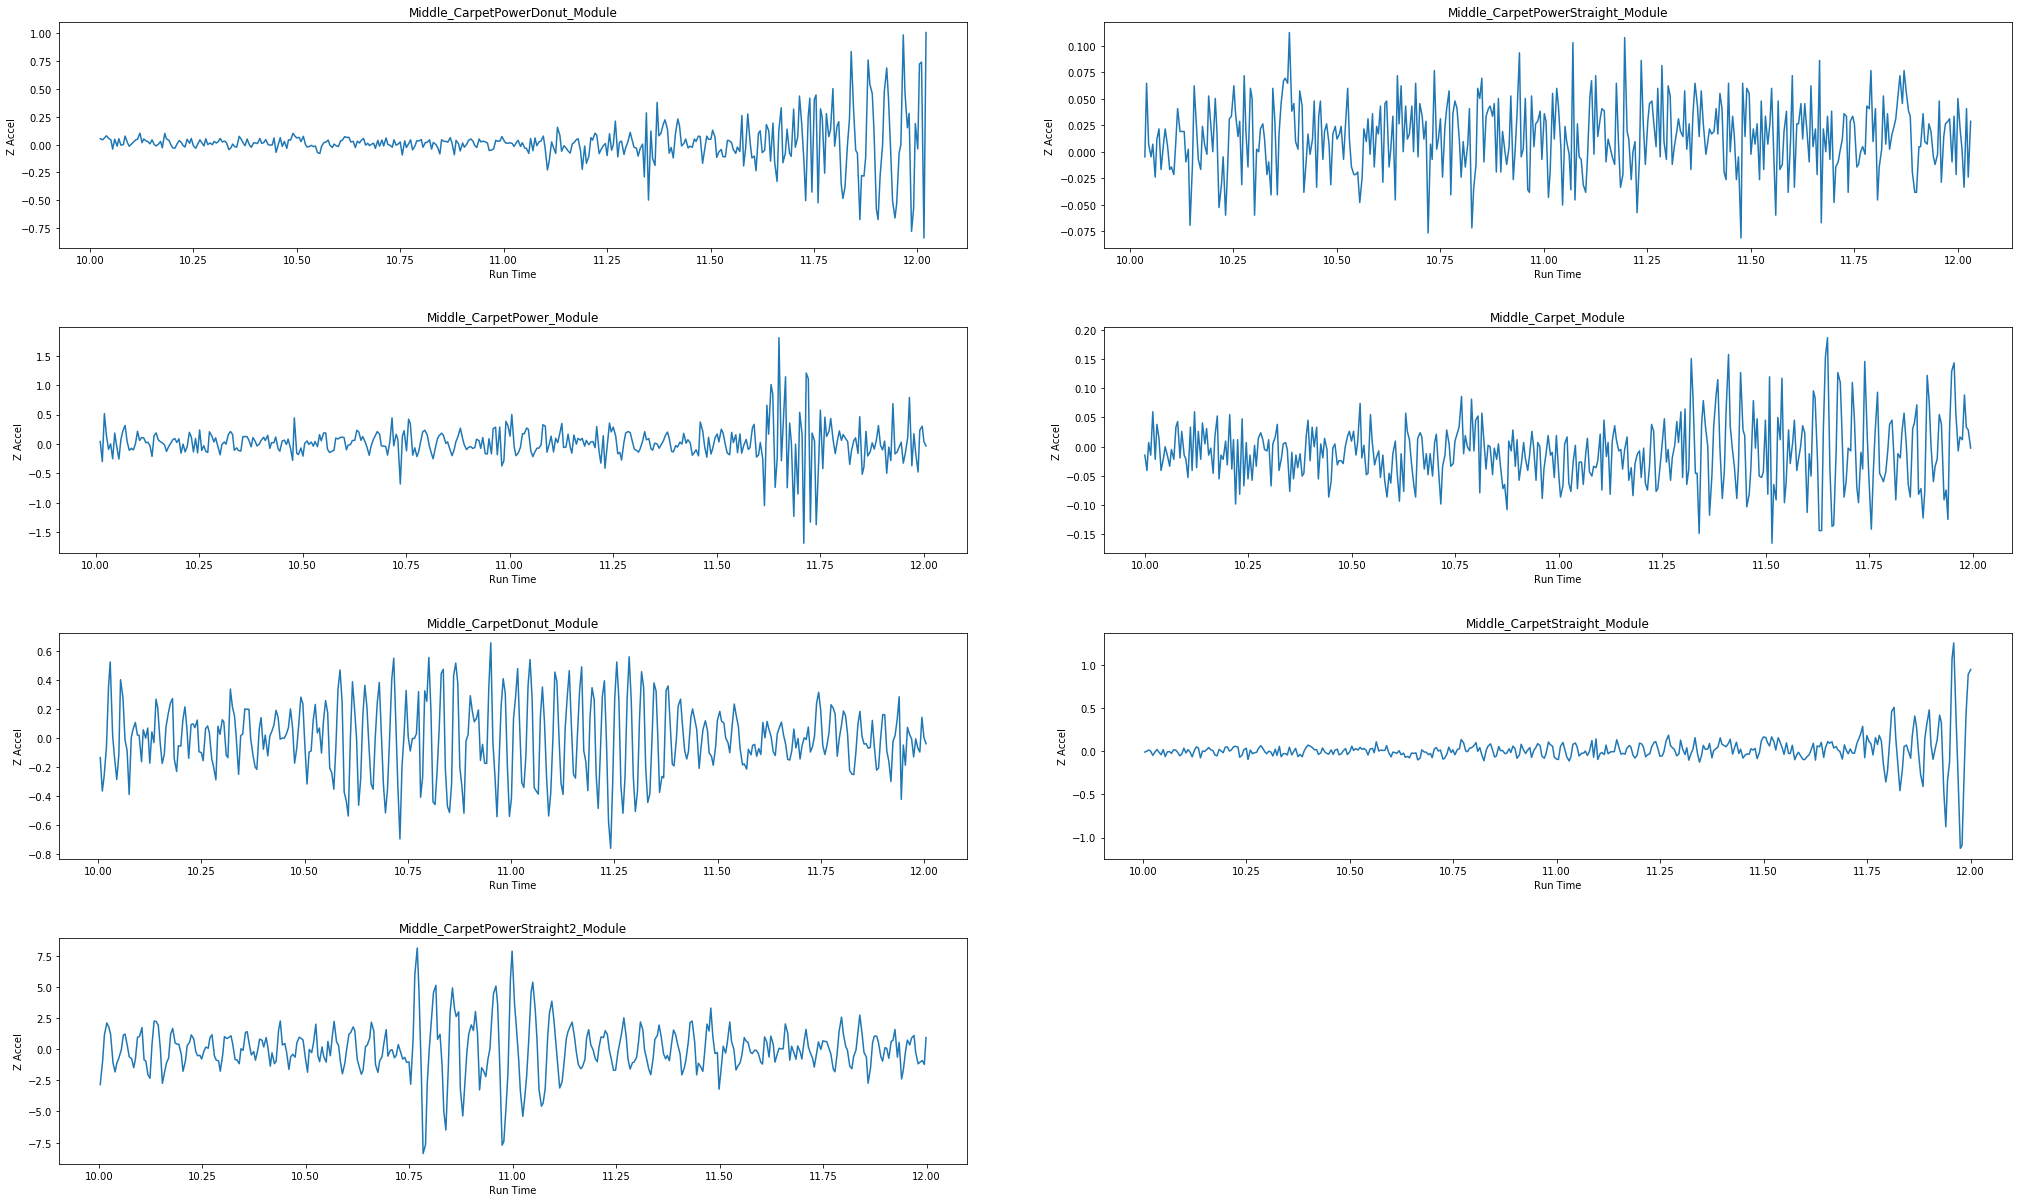

In [29]:
# Plot the first time window
datasets_to_plot = {label: dataset for label, dataset in datasets_windowed.items() if 'Middle' in label and 'Carpet' in label}
plot_all(np_to_pd(datasets_to_plot, windowed=True), 
         x_axis='Run Time', y_axis='Z Accel', windowed=True, win_num=0)

## Part 4 - FFT and PSD

In [30]:
'''Plot tranform of given direction and window'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name):
    plt.clf()
    plt.figure(figsize=(16, 10))
    
    # Plot all the FFTs in one figure overlaid
    for label, dataset in datasets_transformed.items():
        plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                 label=label)
    plt.legend()

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')

    plt.title(transform_name +' of ' + data_columns[dirn] + 
              ', Window {}, Window Size = {} Data Points'.format(win_num, WINDOW_SIZE))
    plt.show()

### Part (a) - FFT
Its possible the FFT is not valid due to the non determinisitic update rate. Probably needs some interpolation.

In [31]:
datasets_fft = {}

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Number of frequency bins is half of window size to trim the symmetric higher frequencies
        n_bins = int(WINDOW_SIZE / 2)
        window_fft = np.zeros((n_bins, N_DATA_COL))
        
        # Sampling frequency dependent on device
        f_samp, f_low, f_high = get_frequencies(label)
        
        for i in range(N_DATA_COL):
            # FFT is normalized to window size, to ensure consistency between different size choices
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), WINDOW_SIZE)), n_bins)
            
        freq_col = np.transpose([np.linspace(0.0, f_samp / 2, n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + 'FFT': dataset_fft})

In [32]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[4]+'FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[4]+'FFT'][0].shape))

# Pandas conversion
np_to_pd(datasets_fft, windowed=True)[dataset_labels[0]+'FFT'][0].head()

Num of FFT'd windowed datasets: 105
Num of FFT'd windows in first dataset: 88
Shape of FFT'd individual window: (200, 7)


X Accel   Y Accel   Z Accel    X Gyro    Y Gyro   Z Gyro  Frequency
0  2.020993  2.429665  0.281102  0.037170  0.180447  4.34627   0.000000
1  1.251021  0.560841  0.037237  0.002121  0.002544  0.00000   0.502513
2  4.587729  4.059706  0.160955  0.004757  0.008522  0.00000   1.005025
3  1.324526  1.749173  0.066929  0.010059  0.004426  0.00000   1.507538
4  0.386911  0.703599  0.025501  0.002806  0.004051  0.00000   2.010050

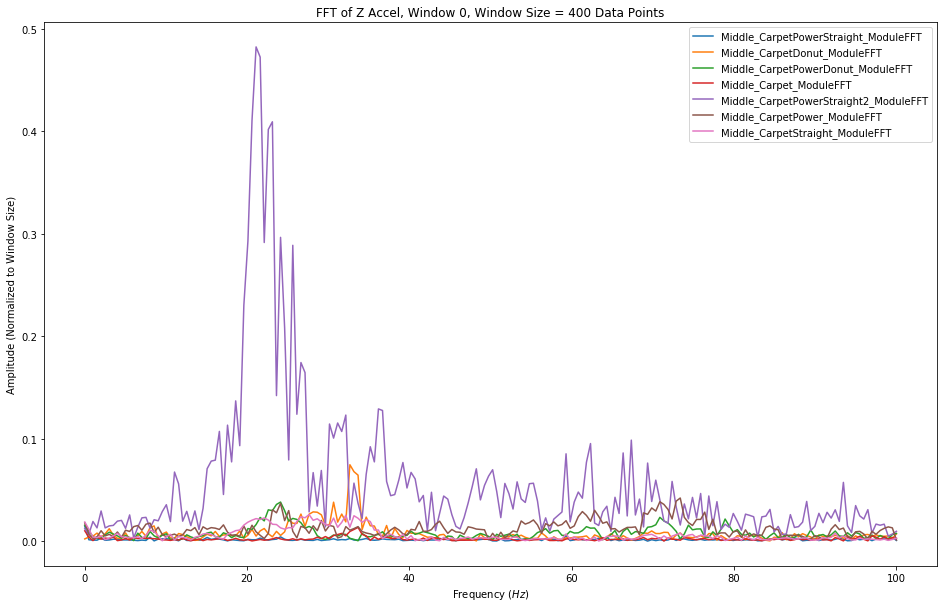

In [33]:
# Plot Z Accel of 0th window, Frame only
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'Carpet' in label}
plot_set_transforms(ffts_to_plot, win_num=0, dirn=2, transform_name='FFT')

The Butterworth cutoff frequency is pretty noticeable. Theres not an easily recognizable cutoff from the unfiltered data.

**The number of frequency bins is dependent on window size, and it seems to affect amplitude too.**

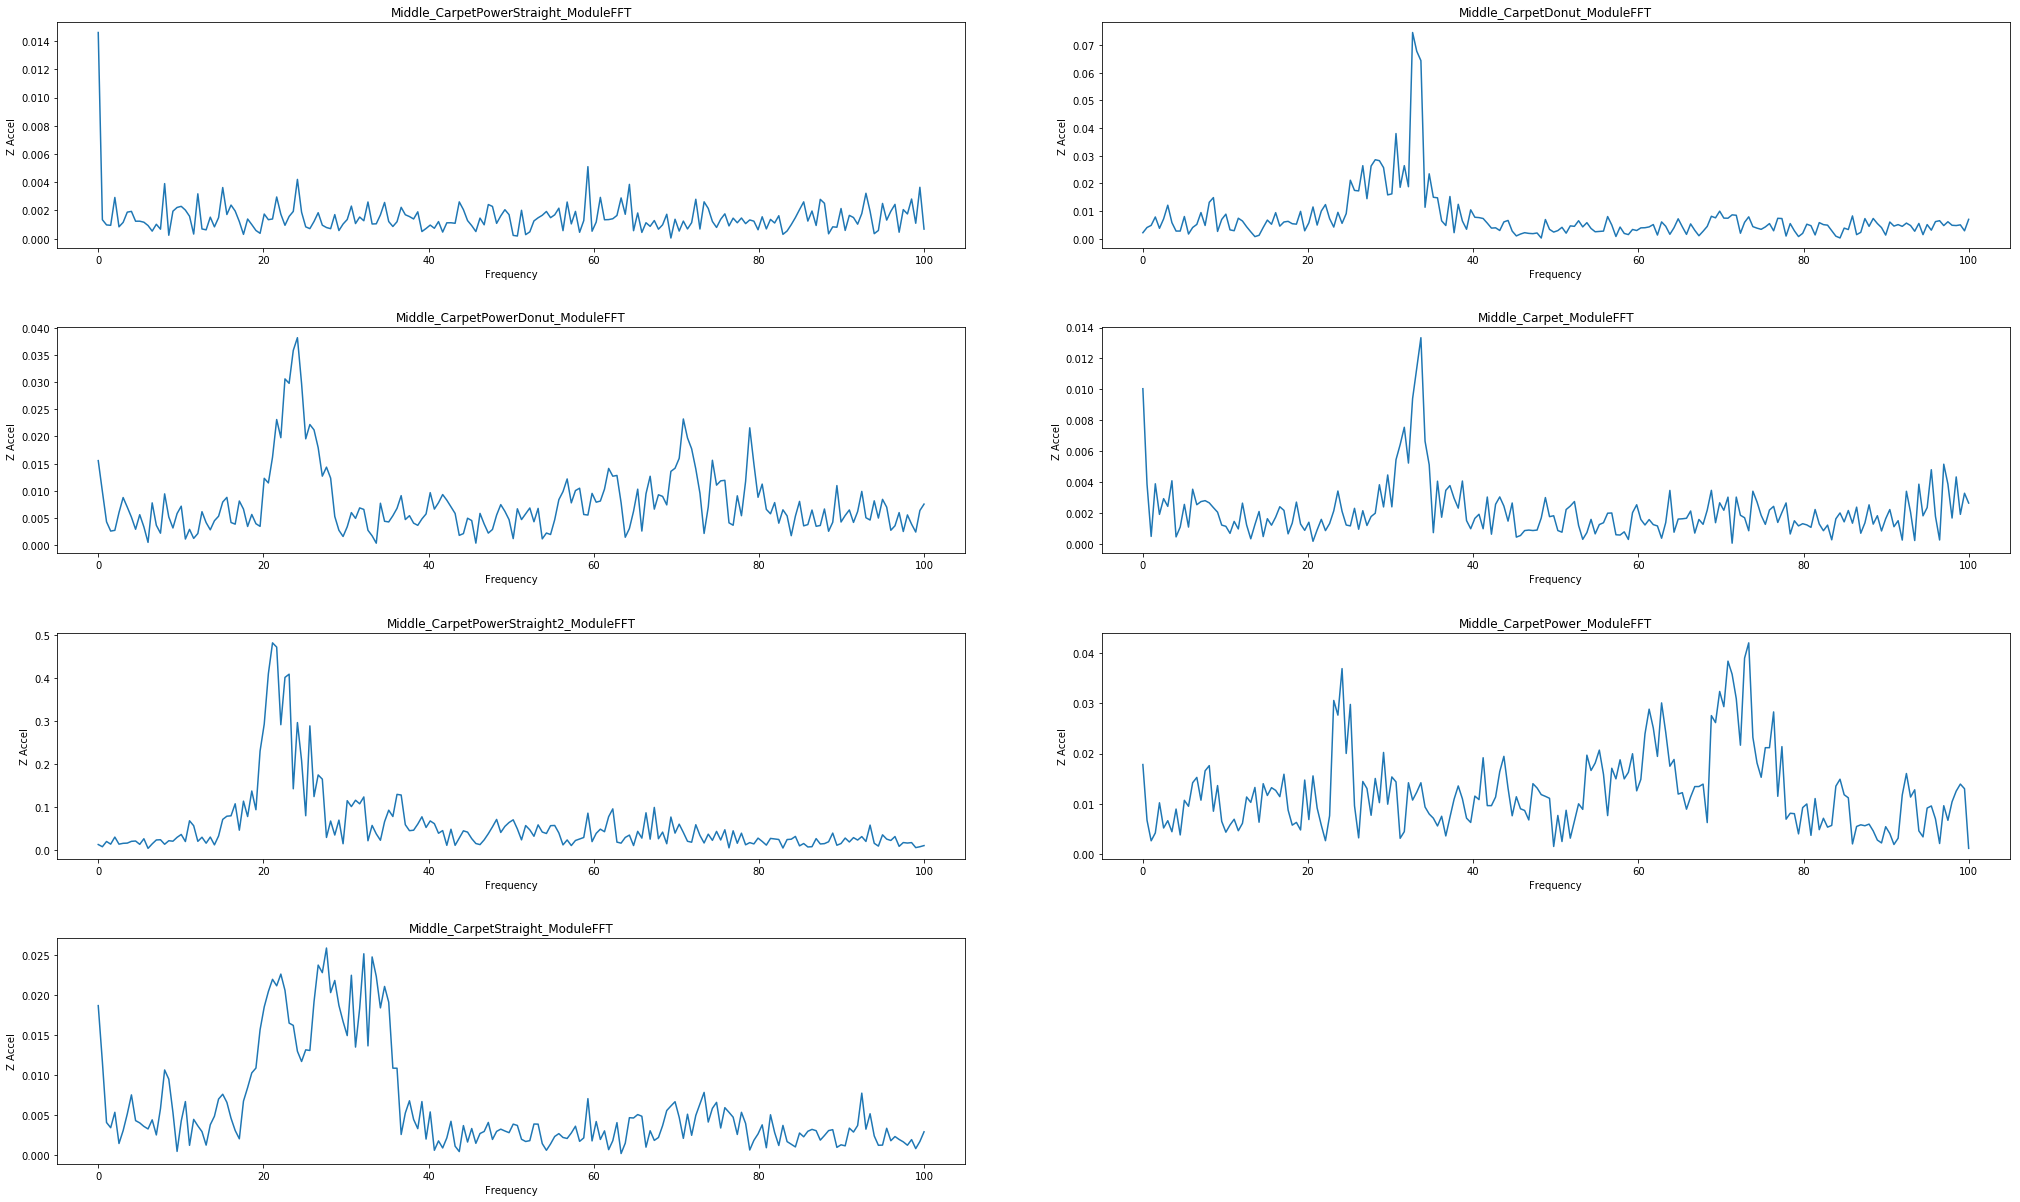

In [34]:
# Plot all the Frame FFTs for 0th window
plot_all(np_to_pd(ffts_to_plot, windowed=True), x_axis='Frequency', y_axis='Z Accel', windowed=True)

### Part (b) - PSD

In [35]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD and log(PSD) of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Number of frequency bins is half of window size to trim the symmetric higher frequencies
        n_bins = int(WINDOW_SIZE / 2)
        window_psd = np.zeros((n_bins, N_DATA_COL))
        window_psd_log = np.zeros((n_bins, N_DATA_COL))
        
        f_samp, f_low, f_high = get_frequencies(label)
        
        for i in range(N_DATA_COL):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], f_samp)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            window_psd_log[:, i] = np.log10(window_psd[:, i])
            
        # Append freq column
        freq_col = np.transpose([freq[:-1]])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + 'PSD': dataset_psd})
    datasets_psd_log.update({label +'PSDLog': dataset_psd_log})

/home/caris/anaconda2/envs/python3.4/lib/python3.4/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log10


In [36]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd[dataset_labels[0]+'PSD'][0].shape))

Num PSD'd windowed datasets: 105
Num of PSD'd windows in first dataset: 6
Shape of PSD'd individual window: (200, 7)


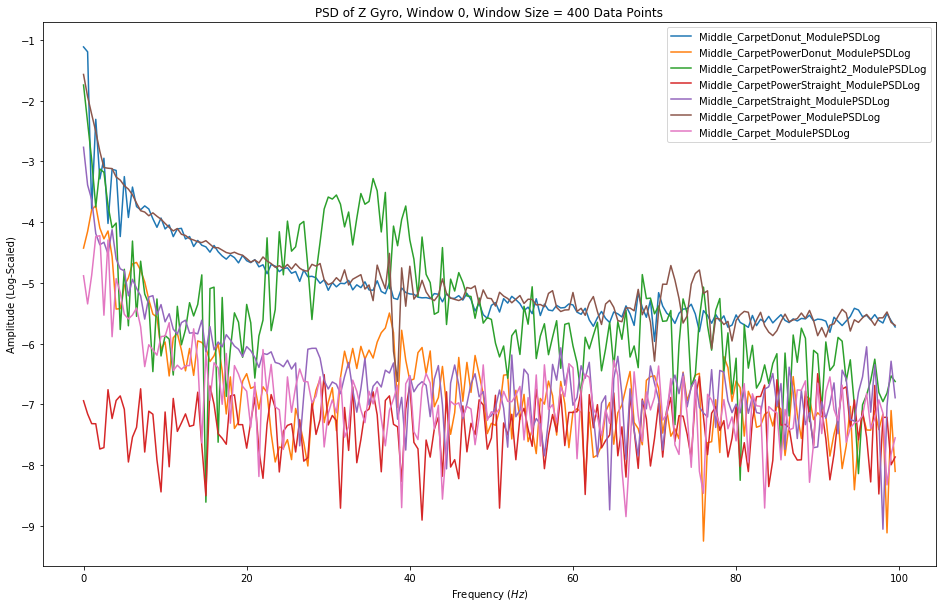

In [37]:
# Plot Z Accel of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'Carpet' in label}
plot_set_transforms(psds_to_plot, win_num=0, dirn=5, transform_name='PSD')

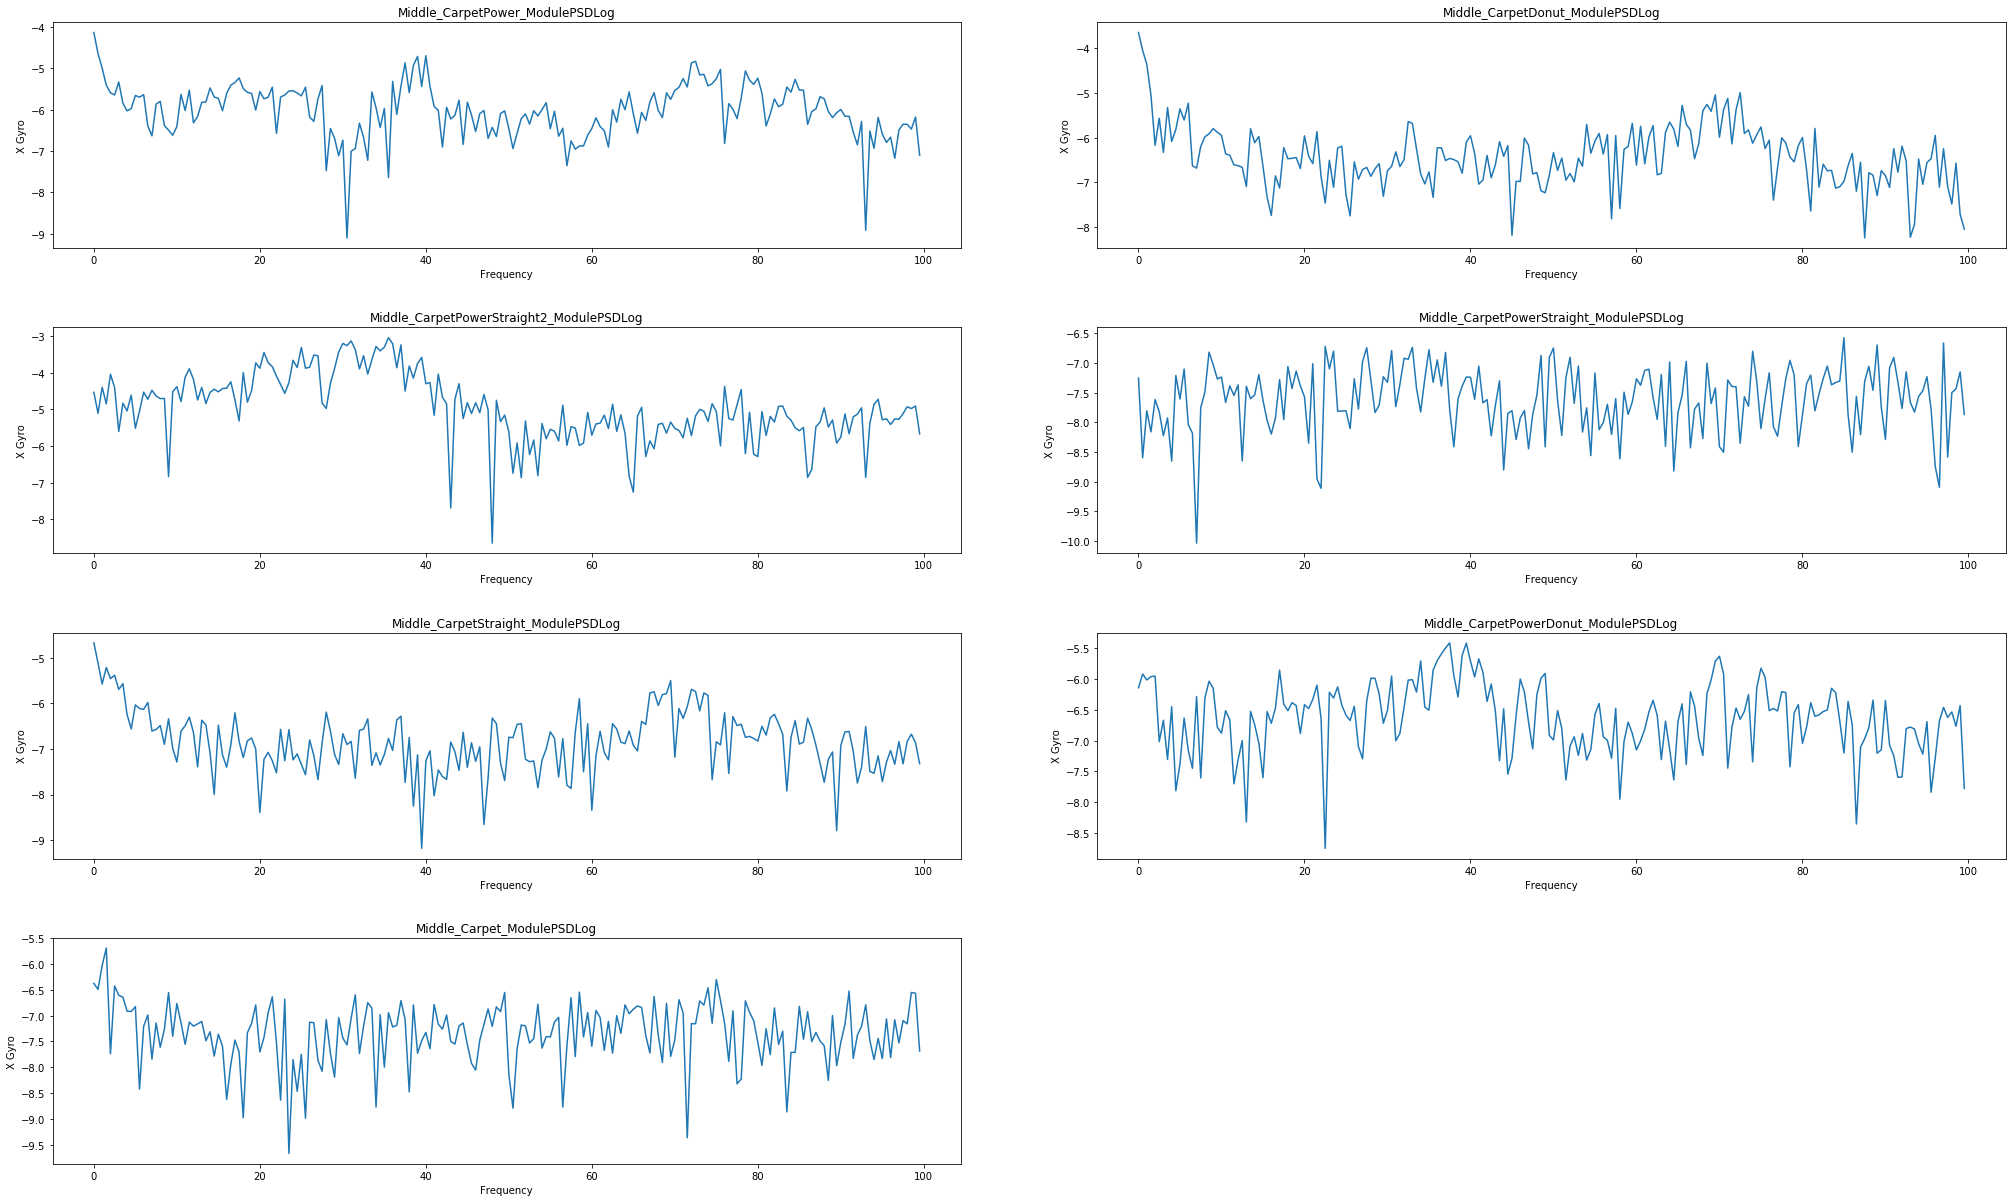

In [38]:
# Plot all PSDs of Z Accel for 0th window
plot_all(np_to_pd(psds_to_plot, windowed=True), x_axis='Frequency', y_axis='X Gyro', windowed=True)

Note that at this point, data is stored like:

`Labelled Terrain Dataset -> Time Window -> 2D NumPy Array Col = Dirn | Frequency)`

### Part (c) - 3D Visualization

In [39]:
'''Plot the set transforms in 3d'''
# TODO: Convert to bar graphs for better representation
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific to FFT or PSD
    if (transform_name == 'FFT'):
        ax.set_zlim(0, 0.8)
        ax.set_zlabel('Amplitude (Normalized)')
    elif (transform_name == 'PSD'):
        ax.set_zlim(-20, 10)
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    # Change y axis to correspond with whats being plotted
    n_datasets = len(datasets_transformed)
    ax.set_ylim(0, n_datasets)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1))
    
    ax.set_xlabel('Frequency ($Hz$)')
    ax.set_title(transform_name + ' of ' + data_columns[dirn] + 
                 ', Window {}, Window Size = {} Data Points'.format(win_num, WINDOW_SIZE))
        
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        ax.plot(xs=dataset[win_num][:, -1], ys=dataset[win_num][:, dirn],
                zs=i+1, zdir='y', label=label)
    
    ax.legend()
    plt.show()

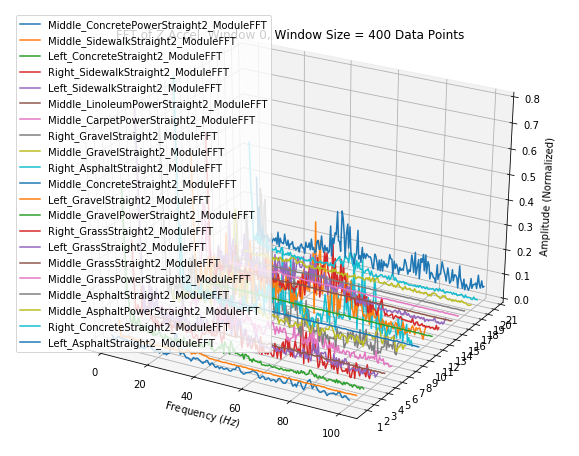

In [40]:
# Plot 3d Z Accel FFT of 0th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Straight2' in label}
plot_transforms_3d(ffts_to_plot, win_num=0, dirn=2, transform_name='FFT')

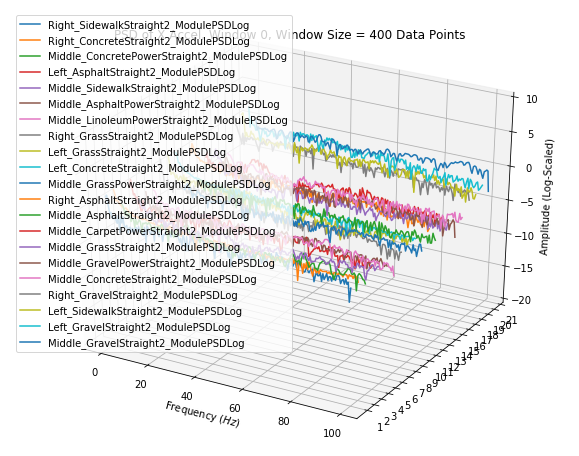

In [41]:
# Plot 3d Z Accel PSD of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Straight2' in label}
plot_transforms_3d(psds_to_plot, win_num=0, dirn=0, transform_name='PSD')

### Part (d) - Spectograms

In [42]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size=WINDOW_SIZE):
    # Get sampling frequency for label
    f_samp, f_low, f_high = get_frequencies(set_label)
    
    plt.clf()
    plt.figure(figsize=(12, 9))
    
    # Compute spectogram directly using time series data
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=f_samp)
    plt.title('Spectrogram of {} for {}'.format(data_columns[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    
    plt.show()

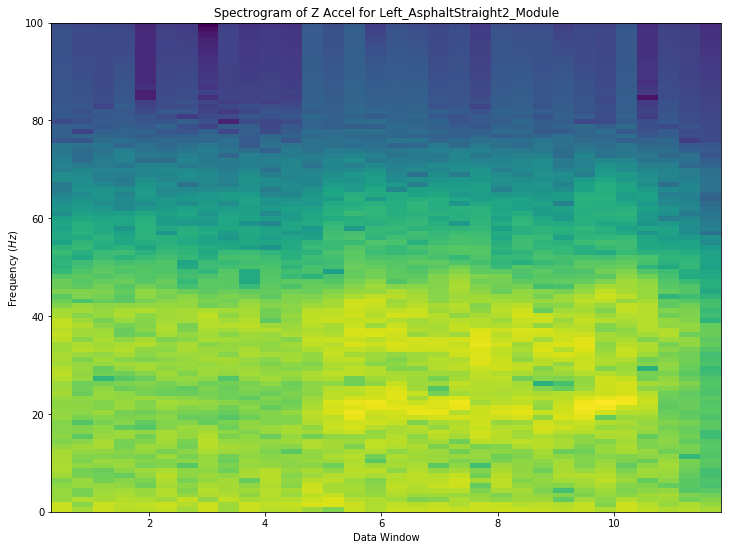

In [43]:
# X Accel
plot_spectogram(dataset_labels[0], dirn=2, size=200)

## Part 5 - Feature Extraction

Structure of feature data:

`Terrain Dataset Dictionary -> Direction Dictionary -> Pandas Array with Row = Window #, Col = Feature`

In [44]:
# Feature extraction functions

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)[0]

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Locations where array > 0, put -1 and 1 for rising/falling,
    # divide by total datapoints
    return len(np.nonzero(np.diff(array > 0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    return np.divide(num, denom)

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    return np.divide(num, denom)

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [45]:
'''Extract given features from everything in dataset'''
def feature_all(features, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = {}
        
        # Loop over data columns
        for i, direction in enumerate(get_columns(label)[:N_DATA_COL]):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window
                    
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, -1], window[:, i]))
                    
                    return feat_in_window
                    
                    
            # Execute every function over all windows    
            for feat_name, feat_func in features.items():
                feats.update({feat_name: function_all_windows(feat_func)})
            
            directions.update({direction: pd.DataFrame.from_dict(feats)})

        datasets_feat.update({label.replace('PSD', ''): directions})
    
    return datasets_feat

In [46]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, dirn, feat_name):
    plt.clf()
    plt.figure(figsize=(10,8))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][feat_name], label=label)
        
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(dirn + ', Window Size = {} Data Points'.format(WINDOW_SIZE))
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [47]:
# Time domain feature function names and actual names
time_features = {'Mean': np.mean, 'Std Dev': np.std,  'L2 Norm': l2norm, 'Autocorrelation': autocorr, 
                 'Max': np.amax, 'Min' : np.amin, 'Root Mean Squared': rms, 'Zero Crossing Rate': zcr, 
                 'Skew': stats.skew, 'Excess Kurtosis': stats.kurtosis} 
N_TIME_FEATS = len(time_features)

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_features, datasets_windowed)

In [48]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]]['X Gyro'].shape))

Num datasets: 105
Num directions: 6
Shape of first dataset first direction: (6, 10)


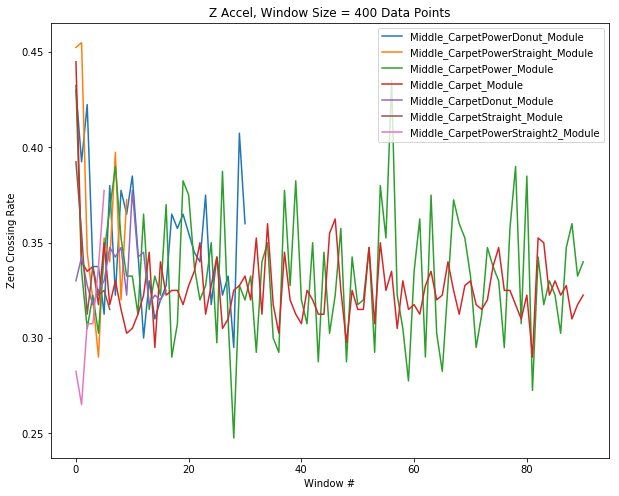

In [49]:
# Plot Max of Z Accel
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Middle' in label and 'Carpet' in label}
plot_set_features(feat_datasets_to_plot, dirn='Z Accel', feat_name='Zero Crossing Rate')

### Part (b) - Frequency Domain Features

In [50]:
# Time domain feature function names and actual names
freq_features = {'Mean Square Frequency': msf, 'Root Mean Square Frequency': rmsf, 'Frequency Center': fc, 
                 'Variance Frequency': vf, 'Root Variance Frequency': rvf}
N_FREQ_FEATS = len(freq_features)

# Calculate features for each window of each column of each dataset
# Create array of features of each window for each dataset and direction
# TODO: Check if psd is correct
datasets_feat_freq = feature_all(freq_features, datasets_psd, regular=False)

/home/caris/anaconda2/envs/python3.4/lib/python3.4/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in true_divide
/home/caris/anaconda2/envs/python3.4/lib/python3.4/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in true_divide


In [51]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[dataset_labels[0]])))
print('Shape of one direction: {}'.format(datasets_feat_freq[dataset_labels[0]]['X Gyro'].shape))

Num datasets: 105
Num directions: 6
Shape of one direction: (6, 5)


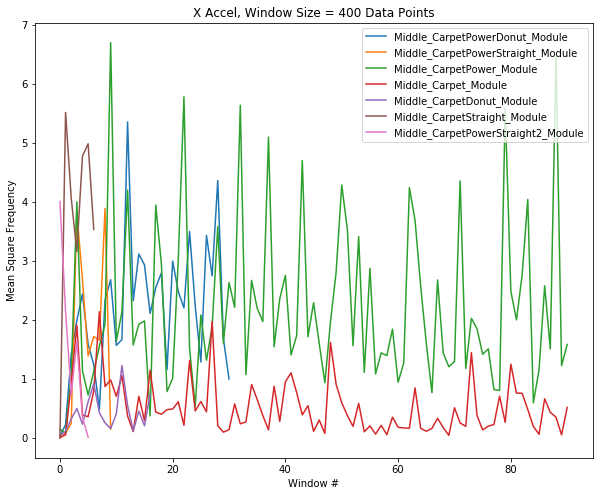

In [52]:
# Plot RVF of Z Accel
feat_datasets_to_plot = {label: feature for label, feature in datasets_feat_freq.items() if 'Middle' in label and 'Carpet' in label}
plot_set_features(feat_datasets_to_plot, dirn='X Accel', feat_name='Mean Square Frequency')

Lots of very similar shapes i.e. highly correlated variables in both time and frequency. Need to implement feature selection.

**Ideally we can implement feature selection over all directions, with FFT + PSD + Time Features + Freq Features**

## Part 5 - Feature Selection

In [53]:
# Convert transformed data to Pandas
datasets_fft = np_to_pd(datasets_fft, windowed=True)
datasets_psd_log = np_to_pd(datasets_psd_log, windowed=True)

In [54]:
# Confirm formatting
datasets_fft[dataset_labels[0]+'FFT'][0].head()

X Accel   Y Accel   Z Accel    X Gyro    Y Gyro   Z Gyro  Frequency
0  2.020993  2.429665  0.281102  0.037170  0.180447  4.34627   0.000000
1  1.251021  0.560841  0.037237  0.002121  0.002544  0.00000   0.502513
2  4.587729  4.059706  0.160955  0.004757  0.008522  0.00000   1.005025
3  1.324526  1.749173  0.066929  0.010059  0.004426  0.00000   1.507538
4  0.386911  0.703599  0.025501  0.002806  0.004051  0.00000   2.010050

In [55]:
# Add time and freq features together
datasets_feat = {}

for label, dataset in datasets_feat_time.items():
    dataset_feat = {}
    
    for dirn_label, dirn_df in dataset.items():
        new_df = dirn_df.join(datasets_feat_freq[label][dirn_label], how='outer')
        dataset_feat.update({dirn_label: new_df})
    
    datasets_feat.update({label: dataset_feat})

In [56]:
# Confirm formatting
datasets_feat[dataset_labels[0]]['X Gyro'].head()

Autocorrelation  Excess Kurtosis   L2 Norm       Max      Mean       Min  \
0         2.119871        -0.087910  1.455978  0.217204  0.037170 -0.142455   
1         3.425170         0.358784  1.850721  0.308151  0.036416 -0.184267   
2        12.807206         0.292342  3.578716  0.501630  0.078245 -0.435137   
3        13.707647         1.065196  3.702384  0.702699  0.014698 -0.691599   
4         8.710007         0.950310  2.951272  0.516677  0.007018 -0.508773   

   Root Mean Squared      Skew   Std Dev  Zero Crossing Rate  \
0           0.072799 -0.053282  0.062594              0.2575   
1           0.092536  0.424817  0.085069              0.1975   
2           0.178936 -0.176997  0.160921              0.2250   
3           0.185119 -0.114276  0.184535              0.3500   
4           0.147564 -0.103189  0.147397              0.2925   

   Frequency Center  Mean Square Frequency  Root Mean Square Frequency  \
0         25.040176               0.002974                    0.054538   
1         13.966971               0.003612                    0.060096   
2         18.580521               0.016886                    0.129947   
3         33.907082               0.082664                    0.287514   
4         27.167683               0.044979                    0.212083   

   Root Variance Frequency  Variance Frequency  
0                 0.054538         -627.007421  
1                 0.060096         -195.072681  
2                 0.129947         -345.218872  
3                 0.287514        -1149.607513  
4                 0.212083         -738.038019

### Part (a) - Standardization

Standardize each feature to mean 0 and standard deviation 1. This will make PCA and classification easier.

In [57]:
'''Normalize already featured datasets'''
def normalize_datasets(datasets, windowed=False):
    datasets_norm = {}
    for label, dataset in datasets.items():
        if windowed:
            dataset_norm = []
            for window_df in dataset:
                window_df = window_df.dropna()
                dataset_norm.append(window_df.apply(pre.scale))
        else:
            dataset_norm = {}
            for dirn_label, dirn_df in dataset.items():
                dirn_df = dirn_df.dropna()
                dataset_norm.update({dirn_label: dirn_df.apply(pre.scale)})
        
        datasets_norm.update({label: dataset_norm})
    
    return datasets_norm

In [58]:
# So we can remove infinites
pd.set_option('use_inf_as_null', True)

datasets_feat_norm = normalize_datasets(datasets_feat)
datasets_fft_norm = normalize_datasets(datasets_fft, windowed=True)
datasets_psd_norm = normalize_datasets(datasets_psd_log, windowed=True)

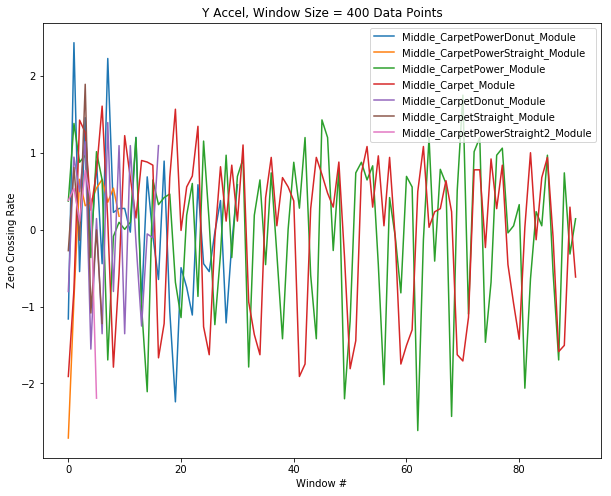

In [59]:
# Plot normalized features
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_norm.items() if 'Middle' in label and 'Carpet' in label}
plot_set_features(feat_datasets_to_plot, dirn='Y Accel', feat_name='Zero Crossing Rate')

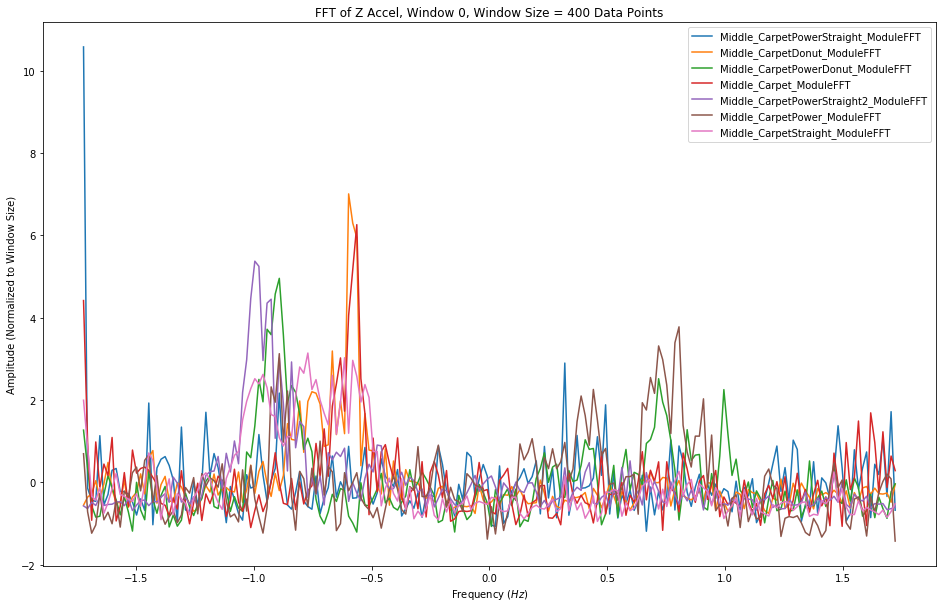

In [60]:
# Plot normalized fft
ffts_to_plot = {label: dataset for label, dataset in datasets_fft_norm.items() if 'Middle' in label and 'Carpet' in label}
plot_set_transforms(pd_to_np(ffts_to_plot, windowed=True), dirn=2, win_num=0, transform_name='FFT')

In [61]:
'''Append a tag to the end of every column name of a dataframe'''
def append_all_columns(columns, append_tag):
    new_columns = []
    
    for column in columns:
        new_columns.append(column + ' ' + append_tag)
    
    return new_columns

### Part (b) - Featured Data

In [62]:
'''Combined directions of a featured dataset'''
def combine_dirns(datasets):
    datasets_combined = {}
    
    for label, dataset in datasets.items():
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for dirn_label, dirn_df in dataset.items():
            df_copy = pd.DataFrame(dirn_df)
            
            # Add direction and placement tags
            df_copy.columns = append_all_columns(dirn_df.columns, dirn_label)
            df_copy.columns = append_all_columns(dirn_df.columns, get_placement(label))
            
            df_combined = df_combined.join(dirn_df, how='outer')
        
        datasets_combined.update({label: df_combined})
    
    return datasets_combined

In [63]:
# Take frame data and combine directions
datasets_feat_combined = combine_dirns(datasets_feat_norm)

# Check dataset
datasets_feat_combined[dataset_labels[3]].head()

Autocorrelation Y Accel Right  Excess Kurtosis Y Accel Right  \
0                      -0.427325                       0.034038   
1                      -0.181369                      -0.006983   
2                       1.001577                      -1.290432   
3                      -1.941347                      -0.153334   
4                       1.350931                      -1.515991   

   L2 Norm Y Accel Right  Max Y Accel Right  Mean Y Accel Right  \
0              -0.385896           0.873668           -0.022367   
1              -0.137904           1.474355            0.912791   
2               0.988716           0.510699           -0.002063   
3              -2.047998          -2.484218           -1.058708   
4               1.303160          -0.101065            0.029986   

   Min Y Accel Right  Root Mean Squared Y Accel Right  Skew Y Accel Right  \
0          -0.426932                        -0.385896            0.350095   
1          -0.204741                        -0.137904           -0.751962   
2          -0.229601                         0.988716           -0.221720   
3          -0.235816                        -2.047998            0.203688   
4          -0.571434                         1.303160           -0.049424   

   Std Dev Y Accel Right  Zero Crossing Rate Y Accel Right  \
0               0.178908                          0.356978   
1              -0.142472                          1.903885   
2               1.140626                         -0.029748   
3              -1.358592                          0.356978   
4               1.356633                         -0.803202   

                ...                 Min Z Gyro Right  \
0               ...                        -2.207158   
1               ...                        -1.770265   
2               ...                        -0.921766   
3               ...                        -0.073266   
4               ...                         1.311400   

   Root Mean Squared Z Gyro Right  Skew Z Gyro Right  Std Dev Z Gyro Right  \
0                        2.586169          -1.079179              0.427533   
1                        1.707390          -0.516905              0.793598   
2                       -0.310238           0.548580              1.206703   
3                        0.291487           1.323216              0.758801   
4                       -0.591445           0.890528             -1.636594   

   Zero Crossing Rate Z Gyro Right  Frequency Center Z Gyro Right  \
0                              0.0                      -0.928665   
1                              0.0                      -0.851213   
2                              0.0                       0.195037   
3                              0.0                      -1.078876   
4                              0.0                       1.281740   

   Mean Square Frequency Z Gyro Right  \
0                           -0.629966   
1                            0.423313   
2                            1.344360   
3                           -0.667775   
4                           -0.604134   

   Root Mean Square Frequency Z Gyro Right  \
0                                -0.633884   
1                                 0.704676   
2                                 1.426827   
3                                -0.717980   
4                                -0.580317   

   Root Variance Frequency Z Gyro Right  Variance Frequency Z Gyro Right  
0                             -0.633884                         0.871628  
1                              0.704676                         0.856064  
2                              1.426827                         0.089968  
3                             -0.717980                         0.932380  
4                             -0.580317                        -1.345797  

[5 rows x 90 columns]

### Part (b) - Transformed Data

In [130]:
'''Combined direction columns for transformed data'''
def combine_transform_dirns(datasets):
    combined_datasets = {}
    
    for label, dataset in datasets.items():
        combined_windows = []
        
        for window in dataset:
            window_as_row = pd.DataFrame()
            
            # Turn each window 2D dataframe into a single row dataframe
            for row in window.iterrows():
                for data_column in data_columns:
                    combined_column_name = data_column + ' {} Hz'.format(round(row[1]['Frequency'], 2))
                    window_as_row.insert(-1, combined_column_name, [row[1][data_column]])
            
            combined_windows.append(window_as_row)
        
        # Combine all the single row dataframes into one dataframe
        combined_datasets.update({label: pd.concat(combined_windows, ignore_index=True)})
    
    return combined_datasets

In [ ]:
datasets_fft_combined = combine_transform_dirns(datasets_fft)

In [ ]:
# Check dataset
datasets_fft_combined[dataset_labels[3]+'FFT'].head()

### Part (c) - Adding Labels

In [64]:
'Add labels to a dataset'
def insert_labels(datasets):
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        terrain_num = get_terrain_num(label)
        labels = [terrain_num for _ in range(len(dataset))]
        dataset.insert(0, 'Label', labels)

In [65]:
# Add labels
insert_labels(datasets_feat_combined)
#insert_labels(datasets_fft, windowed=True)
#insert_labels(datasets_psd_log, windowed=True)

In [91]:
# Check labelled feature data
datasets_feat_combined[dataset_labels[104]].head()

Label  Autocorrelation Y Accel Middle  Excess Kurtosis Y Accel Middle  \
0      5                       -1.493209                        2.134875   
1      5                       -1.233553                        0.220632   
2      5                        0.264387                       -0.536592   
3      5                        0.930686                       -0.614714   
4      5                        1.030007                       -0.639352   

   L2 Norm Y Accel Middle  Max Y Accel Middle  Mean Y Accel Middle  \
0               -1.755641           -2.054286            -1.218515   
1               -0.965532           -0.454425            -0.533140   
2                0.431543            0.627178            -0.145669   
3                0.827716            0.627178             1.841375   
4                0.881844            0.627178            -0.611376   

   Min Y Accel Middle  Root Mean Squared Y Accel Middle  Skew Y Accel Middle  \
0            2.134645                         -1.755641             2.077692   
1            0.225419                         -0.965532            -1.026268   
2           -0.590016                          0.431543            -0.750678   
3           -0.590016                          0.827716            -0.022954   
4           -0.590016                          0.881844            -0.021973   

   Std Dev Y Accel Middle                ...                 \
0               -1.774533                ...                  
1               -0.938834                ...                  
2                0.434417                ...                  
3                0.822248                ...                  
4                0.876373                ...                  

   Min Z Gyro Middle  Root Mean Squared Z Gyro Middle  Skew Z Gyro Middle  \
0           1.807120                        -1.814158            2.125474   
1           0.887029                        -0.832460           -0.521629   
2          -0.829994                         0.441490           -0.977608   
3          -0.879821                         0.979026           -0.452494   
4          -0.486526                         0.848392            0.044850   

   Std Dev Z Gyro Middle  Zero Crossing Rate Z Gyro Middle  \
0              -1.812108                         -0.202168   
1              -0.842182                         -2.102548   
2               0.443086                          0.444770   
3               0.951082                          0.404336   
4               0.866872                          0.485203   

   Frequency Center Z Gyro Middle  Mean Square Frequency Z Gyro Middle  \
0                       -1.886557                            -1.503928   
1                       -0.725422                            -1.244774   
2                        0.605453                             0.743856   
3                        0.339494                             1.096767   
4                        0.686312                             0.554574   

   Root Mean Square Frequency Z Gyro Middle  \
0                                 -1.766097   
1                                 -0.961286   
2                                  0.718980   
3                                  0.911535   
4                                  0.609446   

   Root Variance Frequency Z Gyro Middle  Variance Frequency Z Gyro Middle  
0                              -1.766097                          1.664702  
1                              -0.961286                          0.989697  
2                               0.718980                         -0.579259  
3                               0.911535                         -0.197586  
4                               0.609446                         -0.702048  

[5 rows x 91 columns]

### Part (d) - Combining Datasets

In [67]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [83]:
# Combine all data individually
# TODO: Combine each direction of a single dataset into a single dataframe so we can select across 
datasets_middle = {label: dataset for label, dataset in datasets_feat_combined.items() if 'Middle' in label}
datasets_left = {label: dataset for label, dataset in datasets_feat_combined.items() if 'Left' in label}
datasets_right = {label: dataset for label, dataset in datasets_feat_combined.items() if 'Right' in label}

middle_feats_all = combine_datasets(datasets_middle)
left_feats_all = combine_datasets(datasets_left)
right_feats_all = combine_datasets(datasets_right)

# Export to csv
middle_feats_all.to_csv('featured_data/Middle_Features.csv', index=False)
left_feats_all.to_csv('featured_data/Left_Features.csv', index=False)
right_feats_all.to_csv('featured_data/Right_Features.csv', index=False)

# Drop any row with a NaN
middle_feats_all = middle_feats_all.dropna()
left_feats_all = left_feats_all.dropna()
right_feats_all = right_feats_all.dropna()

# Check that terrains are valid, converting back to terrain names
middle_feats_all.head()

Label  Autocorrelation Y Accel Middle  Excess Kurtosis Y Accel Middle  \
0      1                       -1.831327                        0.550543   
1      1                       -1.550109                       -0.541710   
2      1                       -1.198593                       -0.400254   
3      1                        0.702997                        0.611407   
4      1                       -0.663979                       -0.544252   

   L2 Norm Y Accel Middle  Max Y Accel Middle  Mean Y Accel Middle  \
0               -3.073458           -1.522452            -0.067036   
1               -2.123998           -1.103204             0.116017   
2               -1.418992           -0.497367             0.238175   
3                0.801231            1.302867            -0.470833   
4               -0.633848           -1.067498            -1.292828   

   Min Y Accel Middle  Root Mean Squared Y Accel Middle  Skew Y Accel Middle  \
0            1.338837                         -3.073458            -2.188926   
1            1.076758                         -2.123998             0.648751   
2            0.904368                         -1.418992             0.020656   
3           -1.290108                          0.801231             0.842721   
4            0.221798                         -0.633848            -0.806725   

   Std Dev Y Accel Middle                ...                 \
0               -2.895070                ...                  
1               -1.928280                ...                  
2               -1.200011                ...                  
3                1.368039                ...                  
4               -0.901249                ...                  

   Min Z Gyro Middle  Root Mean Squared Z Gyro Middle  Skew Z Gyro Middle  \
0           0.332412                        -1.668003            3.165619   
1           0.311266                        -1.135090            0.693536   
2           0.075917                        -1.585045           -0.622369   
3           0.371476                        -1.367224            2.169091   
4           1.584544                         0.905573            0.175894   

   Std Dev Z Gyro Middle  Zero Crossing Rate Z Gyro Middle  \
0              -1.479775                         -0.008079   
1               0.243267                         -0.008079   
2              -1.506290                          1.777301   
3              -0.685438                          1.462234   
4              -1.294135                         -0.533190   

   Frequency Center Z Gyro Middle  Mean Square Frequency Z Gyro Middle  \
0                        0.686228                            -0.809671   
1                       -1.005639                             0.909728   
2                       -0.349735                            -0.999396   
3                        3.696649                             0.069837   
4                       -0.095666                             0.221851   

   Root Mean Square Frequency Z Gyro Middle  \
0                                 -0.867306   
1                                  1.032087   
2                                 -1.454849   
3                                  0.322639   
4                                  0.467195   

   Root Variance Frequency Z Gyro Middle  Variance Frequency Z Gyro Middle  
0                              -0.867306                         -0.415673  
1                               1.032087                          0.747330  
2                              -1.454849                          0.415624  
3                               0.322639                         -5.049594  
4                               0.467195                          0.252329  

[5 rows x 91 columns]

### Part (e) - mRMR (minimum Redunancy Maximum Relevance)

Necessary because of the number of different features/transforms in each direction.

Try to find which features are most relevant, from all directions.

In [84]:
# TODO: Compare different libraries
# TODO: Run on FFT data

# Use mRMR to select top features
pymrmr.mRMR(data=middle_feats_all, method='MID', nfeats=20)

['Zero Crossing Rate Y Accel Middle',
 'Mean Z Accel Middle',
 'Mean Square Frequency Y Accel Middle',
 'Skew X Gyro Middle',
 'Variance Frequency Z Accel Middle',
 'Zero Crossing Rate Z Gyro Middle',
 'Excess Kurtosis Y Accel Middle',
 'Excess Kurtosis Z Gyro Middle',
 'Min Z Accel Middle',
 'Mean Y Gyro Middle',
 'Frequency Center Y Accel Middle',
 'Skew Z Accel Middle',
 'Mean X Accel Middle',
 'Variance Frequency Z Gyro Middle',
 'Skew Y Gyro Middle',
 'Mean Square Frequency Z Gyro Middle',
 'Variance Frequency X Gyro Middle',
 'Excess Kurtosis X Accel Middle',
 'Zero Crossing Rate Y Gyro Middle',
 'Variance Frequency X Accel Middle']

In [85]:
# Use mRMR to select top features
pymrmr.mRMR(data=left_feats_all, method='MID', nfeats=20)

['Frequency Center Y Accel Left',
 'Zero Crossing Rate Y Gyro Left',
 'Root Variance Frequency X Accel Left',
 'Frequency Center Z Gyro Left',
 'Std Dev X Accel Left',
 'Root Variance Frequency Z Accel Left',
 'Excess Kurtosis X Gyro Left',
 'Zero Crossing Rate X Accel Left',
 'Root Variance Frequency Y Accel Left',
 'Autocorrelation X Gyro Left',
 'Min Y Accel Left',
 'Zero Crossing Rate Z Gyro Left',
 'Max Y Accel Left',
 'Excess Kurtosis Y Gyro Left',
 'Variance Frequency Z Accel Left',
 'Variance Frequency X Accel Left',
 'Mean Square Frequency Z Gyro Left',
 'Excess Kurtosis Z Gyro Left',
 'Min X Accel Left',
 'Max Z Accel Left']

In [86]:
# Use mRMR to select top features
pymrmr.mRMR(data=right_feats_all, method='MID', nfeats=20)

['Zero Crossing Rate Y Gyro Right',
 'Variance Frequency Z Accel Right',
 'Std Dev X Accel Right',
 'Zero Crossing Rate Z Gyro Right',
 'Root Variance Frequency X Accel Right',
 'Autocorrelation X Gyro Right',
 'Min Y Accel Right',
 'Zero Crossing Rate Y Accel Right',
 'Zero Crossing Rate X Accel Right',
 'Frequency Center Y Accel Right',
 'Variance Frequency X Gyro Right',
 'Excess Kurtosis Z Gyro Right',
 'Skew Z Accel Right',
 'Skew X Gyro Right',
 'Mean Square Frequency X Gyro Right',
 'Root Variance Frequency Z Accel Right',
 'Root Variance Frequency Y Accel Right',
 'Frequency Center Y Gyro Right',
 'Zero Crossing Rate X Gyro Right',
 'Mean Square Frequency Z Gyro Right']

### Part (f) - Compare Indoor and Outdoor Terrains

In [87]:
# Retrieve indoor/outdoor terrains only
indoor_terrains = ['Carpet', 'Concrete', 'Linoleum']
datasets_middle_indoor = {label: dataset for label, dataset in datasets_middle.items() if any(terrain in label for terrain in indoor_terrains)}

outdoor_terrains = ['Grass', 'Sidewalk', 'Asphalt', 'Gravel']
datasets_middle_outdoor = {label: dataset for label, dataset in datasets_middle.items() if any(terrain in label for terrain in outdoor_terrains)}

In [89]:
# Indoor terrains
pymrmr.mRMR(data=combine_datasets(datasets_middle_indoor), method='MID', nfeats=20)

['Mean Square Frequency Z Accel Middle',
 'Skew Y Accel Middle',
 'Mean Z Accel Middle',
 'Variance Frequency Z Gyro Middle',
 'Excess Kurtosis X Accel Middle',
 'Mean Square Frequency Z Gyro Middle',
 'Excess Kurtosis Z Gyro Middle',
 'Zero Crossing Rate Y Gyro Middle',
 'Skew Y Gyro Middle',
 'Frequency Center Y Accel Middle',
 'Skew Z Accel Middle',
 'Mean Y Gyro Middle',
 'Mean Square Frequency Y Accel Middle',
 'Variance Frequency Z Accel Middle',
 'Excess Kurtosis Y Accel Middle',
 'Mean X Accel Middle',
 'Variance Frequency X Gyro Middle',
 'Skew Z Gyro Middle',
 'Zero Crossing Rate Z Gyro Middle',
 'Mean Square Frequency X Accel Middle']

In [90]:
# Outdoor terrains
pymrmr.mRMR(data=combine_datasets(datasets_middle_outdoor), method='MID', nfeats=20)

['Min Z Accel Middle',
 'Mean Y Gyro Middle',
 'Zero Crossing Rate Z Gyro Middle',
 'Excess Kurtosis Y Gyro Middle',
 'Mean X Accel Middle',
 'Variance Frequency Z Accel Middle',
 'Skew Z Gyro Middle',
 'Mean Square Frequency Y Accel Middle',
 'Frequency Center Y Accel Middle',
 'Mean Z Accel Middle',
 'Skew X Gyro Middle',
 'Mean Y Accel Middle',
 'Variance Frequency Z Gyro Middle',
 'Zero Crossing Rate Y Accel Middle',
 'Excess Kurtosis Y Accel Middle',
 'Skew Z Accel Middle',
 'Zero Crossing Rate Y Gyro Middle',
 'Mean Square Frequency Z Gyro Middle',
 'Skew Y Gyro Middle',
 'Zero Crossing Rate X Gyro Middle']

## Part 6 - PCA and Optimization

### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction` - Linear acceleration or gyroscope in $x,y$ or $z$